##  Clinical Diagnosis Prediction from Medical Transcripts/Anamnesis
#### Member: Joy Zhuge, Gemeng Zhang

### Background

Primary health care is essential for most people, but making an appointment with a doctor could be exhausting and time-consuming in modern life. It would be great to have an AI healthcare chatbot to assure the anxiety before making the reservation. Image the scenario, we can make a self-diagnosis right after having some symptoms, and then decide which specialists to visit.
We attempt to predict clinical diagnosis from medical transcripts/anamnesis, although the prediction might not be accurate at all. On one side, patients can save time and money with a positive attitude; on the other side, doctors can serve more efficiently on sparing time on unreliable diagnosis.


### Dataset Info

We will use the medical transcription sample reports and examples from https://www.mtsamples.com. The data contains around 5000 sample transcription reports for many specialties provided by various transcriptionists and users and are for reference purpose only. The data is also available on Kaggle (https://www.kaggle.com/tboyle10/medicaltranscriptions) . In our problem setting, we are interested in two aspects of the data: the sample medical transcription as features and medical speciality as labels. In the dataset, 40 types of specialties are provided as labels with an unbalanced distribution ((min,max) = (7, 1103)).

In [12]:
# Dependent libraries
# Basic libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import random
import itertools
from collections import defaultdict
import string

# Preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
import gensim.downloader as api
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
#from imblearn.under_sampling import NearMiss, RandomUnderSampler
#from imblearn.over_sampling import SMOTE, ADASYN

# RNN related packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
# import torchtext
# Models

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#import lightgbm as lgb

# Evaluation

from sklearn.metrics import classification_report,f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
#from lime import lime_text
from sklearn.pipeline import make_pipeline
#from lime.lime_text import LimeTextExplainer


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Data Preview

In [2]:
# load data
data = pd.read_csv('mtsamples.csv')
print(data.shape)
data.head()

(4999, 6)


Unnamed: 0                                        description  \
0           0   A 23-year-old white female presents with comp...   
1           1           Consult for laparoscopic gastric bypass.   
2           2           Consult for laparoscopic gastric bypass.   
3           3                             2-D M-Mode. Doppler.     
4           4                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                       transcription  \
0  SUBJECTIVE:,  This 23-year-old white female pr...   
1  PAST MEDICAL HISTORY:, He has difficulty climb...   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4  1.  The left ventricular cavity size and wall ...   

                                            keywords  
0  allergy / immunology, allergic rhinitis, aller...  
1  bariatrics, laparoscopic gastric bypass, weigh...  
2  bariatrics, laparoscopic gastric bypass, heart...  
3  cardiovascular / pulmonary, 2-d m-mode, dopple...  
4  cardiovascular / pulmonary, 2-d, doppler, echo...

After the load the dataset, we can see there are five columns including the "description", "medical_specialty", "sample_name", "transcription" and "keywords". In our project, we are interested in predicting the medical specialty according to the transcription records, so we will only keep those two columns for further use. Moreover, we would like to check if there are any empty entry in the left two columns and discard those entries accordingly.

In [3]:
# extract the medical specialty and transcriptions
data = data[['transcription', 'medical_specialty']]

# remove the data entry with NaN
data = data.drop(data[data['transcription'].isna()].index)
data = data.drop(data[data['medical_specialty'].isna()].index)
print(data.shape)

(4966, 2)


It seems 33 data porints were removed due to the empty entry! Now, let's take a look at our feature, the transcription context. Although it should be vectorized for further modeling, clearly understanding of the words is the pivot for successful feature extraction. The transcription is the detailed description of patients' symptoms from the physicians or doctors. For example, we can show the transcription for the first patient in the list. We can see there are several keywords appearing in the context like "SUBJECTIVE", "MEDICATIONS","ALLERGIES","OBJECTIVE", "ASSESSMENT" and "PLAN", which seems to be a very well-organized text form.


In an ideal condition, we would like the transcription to be a highly structured form, which will be in favor of further analysis. However, we found this tale is not applicable in this pratice as we check more patients data. The transcription of the second patients just has a different list of record: PAST MEDICAL HISTORY, "PAST SURGICAL HISTORY","SOCIAL HISTORY", "FAMILY HISTORY","CURRENT MEDICATIONS", "ALLERGIES","MISCELLANEOUS/EATING HISTORY","REVIEW OF SYSTEMS","PHYSICAL EXAMINATION". There is no doubt that it would be problematic if we just ignore those KEYWORDS and throw the whole paragraph into featurization. It seems we must firstly find a way to make use of (or skip) those KEYWORDS in our featurization. 

Similarly, we can check the meidcal specialty of the data. From the following results, we can see this is a unbalanced multi-classfication problem. There are total 40 labels containing 6 to 1088 samples in different classes. Hence, we also need to take this into consideration in our performance measure and classifier design.

To make the transcription more clear and easier to tokenize, we would like to clean the dat in the following ways:
1. turn all the words into lower case
2. remove all the punctuations
3. remove all the numbers

In [4]:
translator_c = str.maketrans(string.punctuation, ' '*len(string.punctuation))
data['transcription_clear']=data['transcription'].apply(lambda x: ' '.join([i for i in str(x).lower().
                                            translate(translator_c).split(' ') if i.isalpha()]))

In [5]:
category_list = data['medical_specialty'].unique()

In [36]:
from gensim.models import KeyedVectors
bio_wordvec = KeyedVectors.load_word2vec_format("BioWordVec_PubMed_MIMICIII_d200.vec.bin", binary=True);

In [ ]:
# MEAN_VEC = bio_wordvec.vectors.mean(axis=0)
# torch.save(MEAN_VEC, 'BioMeanVec.pt')

In [37]:
# load to save time
MEAN_VEC = torch.load('BioMeanVec.pt')

In [38]:
# Some small functions
def embed_words_rnn(w2v, sentence):
    """
    Embed each token with its vector from w2v.
    """
    # Use mean vector if word not in w2v
    return torch.tensor([w2v[w.lower()] if w.lower() in w2v else MEAN_VEC for w in sentence])

def pure_index(vocab, word):
    return vocab.index(word)

def one_hot(vocab, word):
    x = torch.zeros((1, len(vocab)))
    x[0][vocab.index(word)] = 1.0
    return x

def one_hots(vocab, words):
    return torch.cat([one_hot(vocab, w) for w in words])

def output2label(output, category_list):
    """
     return the letter for the most probable prediction
    """
    top_n, top_i = output.topk(1)
    return category_list[top_i.item()] 

In [39]:
# split the train/test data
def prepare_data(data, feature_column, label_column, w2v,
                 test_size = 0.2, seed = 123, batch_size = 32):
    """
        Input:
            data - dataframe
            feature_column - name of the feature column
            label_column - name of the label column
            w2v - word to vector embedding dict
            test_size
            seed
            batch_size
        
        Output:
            train_loader
            test_loader
    """
    # train test split
    labels = data[label_column].tolist()
    x_train, x_test, y_train, y_test = train_test_split(data[feature_column], labels, stratify = labels, 
                                                    random_state = seed, test_size = test_size, shuffle = True)
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    
    # padding the data to uniform length
    rnn_train = []
    rnn_test = []
    for i in range(len(x_train)):
        rnn_train.append(embed_words_rnn(w2v, x_train[i].split(' ')))
    for i in range(len(x_test)):
        rnn_test.append(embed_words_rnn(w2v, x_test[i].split(' ')))
    train_pad = pad_sequence(rnn_train,  padding_value = 0)
    test_pad = pad_sequence(rnn_test,  padding_value = 0)
    
    # formalize to loader
    train_small = []
    test_small = []

    for i in range(len(x_train)):
        train_small.append([train_pad[:,i,:].squeeze(), pure_index(list(category_list), y_train[i])])
    # 20 samples for test
    for i in range(len(x_test)):
        test_small.append([test_pad[:,i,:].squeeze(), pure_index(list(category_list), y_test[i])])

    train_loader = torch.utils.data.DataLoader(dataset = train_small, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(dataset = test_small, batch_size = batch_size, shuffle = True)
    
    return train_loader, test_loader


In [41]:
class GRU_classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, category_list):
        super(GRU_classifier, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        # self.n_layer = layers
        self.states = category_list
        #self.embedding = nn.Embedding(self.input_size, self.embedding_size)
        self.rnn = nn.GRU(input_size = input_size, hidden_size = hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim = 1)
        # self.dropout = nn.Dropout()
        
    
    def forward(self, inputs):
        # inilization the h0
        h0 = torch.zeros(1, inputs.size(1), self.hidden_size)
        # forward propogation
        hidden, _ = self.rnn(inputs, h0)
        x = self.tanh(hidden)
        # reduce the dimension
        # x = inputs
        x_avg = x.sum(dim = 1) / x.shape[1]
        x_avg = x_avg.squeeze(1)
        # out = self.dropout(x_avg)
        # out = self.hidden2label(out)
        # out = self.softmax(out)
        # exstract the final forward hidden state
        ### use only the last hidden state
        # final_hidden = hidden[:,-1,:]
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(x_avg)

        #Final activation function
        outputs = self.softmax(dense_outputs)
        
        return outputs   
# gru_classfier = GRU_classifier(200, 64, 40, 1)
# print(gru_classfier)

In [42]:
def train_rnn(rnn, train_data, test_data, epochs=40, learning_rate=0.01):
    torch.random.manual_seed(42)  # for reproducibility
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(rnn.parameters(),
                                 lr=learning_rate) 
    rnn.verbose = False
    loss_val = []
    test_acc = []
    # main training loop
    # here, we're updating after each sentence.
    # to improve convergence, we should really use mini-batches (e.g., a group of ~20 sentences)
    # but, this is a bit easier.
    for epoch in tqdm(range(epochs), total=epochs):
        loss_total = 0
        for sentence, tags in train_data:
            optimizer.zero_grad()                             # reset all the gradient information
            outputs = rnn.forward(sentence) # predict on this sentence
            loss = criterion(outputs, tags)                   # compute loss
            loss.backward()                                   # computes all the gradients
            optimizer.step() 
            loss_total += loss.item() # update parameters
        loss_val.append(loss_total/len(train_data))                      # track loss on each sentence
        # after each epoch, record the test accuracy.
        test_acc.append(evaluate_rnn(rnn, test_data, verbose=True))

    # plot training loss
    plt.figure()
    plt.plot(loss_val, 'bo-')
    plt.ylabel('loss')
    plt.xlabel('instance')
    plt.title('training')
    plt.show()
    # plot testing F1
    plt.figure()
    plt.plot(test_acc, 'bo-')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.title('testing')
    plt.show()
    
    return rnn,test_acc

# model evaluation 
def evaluate_rnn(rnn, data, verbose= True):
    # rnn.verbose = False
    truths = []
    preds = []
    for i, (sentence, tag) in enumerate(data):
        outputs = rnn.forward(sentence)
        top_n, top_1 = outputs.topk(1)
        pred = top_1.tolist() 
        truth = tag.tolist()
        # if i%10 ==0:
        #    print(pred)
        #    print(truth)
        truths.extend(truth)
        preds.extend(pred)
    if verbose:
        print(classification_report(truths, preds, zero_division=0))
    return f1_score(truths, preds, average='weighted')

# rnn = GRU_classifier(200, 64, 40, category_list)
# train_rnn(rnn, train_loader, test_loader, epochs=15)

### First try the one layer GRU using the data['transcription_clear'] term

In [43]:
train_loader, test_loader = prepare_data(data, 'transcription_clear', 'medical_specialty', bio_wordvec,
                 test_size = 0.2, seed = 1234, batch_size = 64)

In [44]:
hidden_size = 64
output_size = len(category_list)
rnn = GRU_classifier(200, hidden_size, output_size, category_list)
train_rnn(rnn, train_loader, test_loader, epochs=50)

  2%|█▋                                                                                 | 1/50 [00:56<45:48, 56.10s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

  4%|███▎                                                                               | 2/50 [01:49<44:10, 55.22s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

  6%|████▉                                                                              | 3/50 [02:41<42:33, 54.34s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

  8%|██████▋                                                                            | 4/50 [03:34<41:15, 53.81s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 10%|████████▎                                                                          | 5/50 [04:26<40:08, 53.51s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 12%|█████████▉                                                                         | 6/50 [05:24<40:02, 54.61s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 14%|███████████▌                                                                       | 7/50 [06:21<39:48, 55.54s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 16%|█████████████▎                                                                     | 8/50 [07:20<39:30, 56.44s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 18%|██████████████▉                                                                    | 9/50 [08:14<38:03, 55.70s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 20%|████████████████▍                                                                 | 10/50 [09:05<36:15, 54.38s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 22%|██████████████████                                                                | 11/50 [09:58<35:08, 54.06s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 24%|███████████████████▋                                                              | 12/50 [10:50<33:42, 53.23s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 26%|█████████████████████▎                                                            | 13/50 [11:40<32:20, 52.44s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 28%|██████████████████████▉                                                           | 14/50 [12:33<31:34, 52.63s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 30%|████████████████████████▌                                                         | 15/50 [13:25<30:26, 52.19s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 32%|██████████████████████████▏                                                       | 16/50 [14:18<29:49, 52.64s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 34%|███████████████████████████▉                                                      | 17/50 [15:10<28:45, 52.28s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 36%|█████████████████████████████▌                                                    | 18/50 [16:04<28:09, 52.78s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 38%|███████████████████████████████▏                                                  | 19/50 [16:55<27:04, 52.39s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 40%|████████████████████████████████▊                                                 | 20/50 [17:47<26:03, 52.12s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 42%|██████████████████████████████████▍                                               | 21/50 [18:38<25:05, 51.91s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 44%|████████████████████████████████████                                              | 22/50 [19:28<23:59, 51.40s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 46%|█████████████████████████████████████▋                                            | 23/50 [20:24<23:39, 52.59s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 48%|███████████████████████████████████████▎                                          | 24/50 [21:14<22:30, 51.94s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 50%|█████████████████████████████████████████                                         | 25/50 [22:07<21:45, 52.20s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 52%|██████████████████████████████████████████▋                                       | 26/50 [22:59<20:55, 52.31s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 54%|████████████████████████████████████████████▎                                     | 27/50 [23:52<20:04, 52.39s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 56%|█████████████████████████████████████████████▉                                    | 28/50 [24:45<19:18, 52.65s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 58%|███████████████████████████████████████████████▌                                  | 29/50 [25:36<18:14, 52.11s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 60%|█████████████████████████████████████████████████▏                                | 30/50 [26:29<17:25, 52.29s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 62%|██████████████████████████████████████████████████▊                               | 31/50 [27:20<16:27, 51.96s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 64%|████████████████████████████████████████████████████▍                             | 32/50 [28:14<15:46, 52.60s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 66%|██████████████████████████████████████████████████████                            | 33/50 [29:06<14:50, 52.37s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [29:59<14:01, 52.58s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [30:51<13:05, 52.35s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 72%|███████████████████████████████████████████████████████████                       | 36/50 [31:42<12:09, 52.12s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [32:35<11:20, 52.34s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [33:25<10:20, 51.68s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        45
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        31
           6       0.00      0.00      0.00        52
           7       0.22      1.00      0.36       218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        33
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        11
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00        14
          17       0.00    

KeyboardInterrupt: 

### Top 5 classification using the T5 summarization term

In [45]:
T5_df = pd.read_csv('summary_T5.csv')
T5_df.head(5)
col_names = list(T5_df.columns)
#print(col_names)

In [46]:
T5_df['combined_feature'] = T5_df['SUBJECTIVE']
for column in col_names[3:-3]:
    if column != 'SUBJECTIVE':
        T5_df['combined_feature'].update(T5_df.pop(column))
T5_df.pop('SUBJECTIVE')
# discard the NaN feature
T5_df = T5_df.drop(T5_df[T5_df['combined_feature'].isna()].index)
print(T5_df.shape)
# 
category_list = T5_df['medical_specialty'].unique()
T5_df.head(5)

(4811, 7)


transcription  \
0  SUBJECTIVE:,  This 23-year-old white female pr...   
1  PAST MEDICAL HISTORY:, He has difficulty climb...   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
5  PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...   

             medical_specialty  \
0         Allergy / Immunology   
1                   Bariatrics   
2                   Bariatrics   
3   Cardiovascular / Pulmonary   
5                   Bariatrics   

                                 transcription_clear  \
0  subjective this year old white female presents...   
1  past medical history he has difficulty climbin...   
2  history of present illness i have seen abc tod...   
3  d m mode left atrial enlargement with left atr...   
5  preoperative diagnosis morbid obesity postoper...   

                                    transcription_T5  transcription_len  \
0  SUBJECTIVE:this 23-year-old white female has c...               1331   
1  PAST MEDICAL HISTORY:he has difficulty climbin...               2431   
2  HISTORY OF PRESENT ILLNESS:42-year-old is 5'9"...               4422   
3  MODE:normal LV diastolic function with left ve...                495   
5  PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...               4334   

   transcription_T5_len                                   combined_feature  
0                   592  ,1.  She will try Zyrtec instead of Allegra ag...  
1                   957  , He is alert and oriented x 3.  Cranial nerve...  
2                  1052   , I have seen ABC today.  He is a very pleasa...  
3                   182   , ,1.  Mild mitral and tricuspid regurgitatio...  
5                   430    ,The patient was taken to the operating room...

In [47]:
T5_df['feature_clear']=T5_df['combined_feature'].apply(lambda x: ' '.join([i for i in str(x).lower().translate(translator_c).split(' ') if i.isalpha()]))

In [48]:
T5_df.iloc[0]['feature_clear']

'she will try zyrtec instead of allegra again another option will be to use loratadine she does not think she has prescription coverage so that might be cheaper samples of nasonex two sprays in each nostril given for three weeks a prescription was written as well'

In [49]:
T5_df['medical_specialty'].value_counts()

 Surgery                          1057
 Consult - History and Phy.        510
 Cardiovascular / Pulmonary        360
 Orthopedic                        352
 Radiology                         261
 General Medicine                  253
 Gastroenterology                  222
 Neurology                         220
 SOAP / Chart / Progress Notes     154
 Obstetrics / Gynecology           152
 Urology                           151
 Discharge Summary                 106
 Neurosurgery                       94
 ENT - Otolaryngology               91
 Hematology - Oncology              82
 Nephrology                         75
 Emergency Room Reports             75
 Ophthalmology                      72
 Pediatrics - Neonatal              69
 Pain Management                    60
 Psychiatry / Psychology            52
 Office Notes                       45
 Podiatry                           42
 Dermatology                        29
 Dentistry                          26
 Cosmetic / Plastic Surge

In [50]:
selected_label = [' Surgery',
                  ' Consult - History and Phy.',
                  ' Cardiovascular / Pulmonary',
                  ' Orthopedic',
                  ' Radiology']
top5_t5 = T5_df[T5_df['medical_specialty'].isin(selected_label)]
top5_t5.head(5)

transcription  \
3    2-D M-MODE: , ,1.  Left atrial enlargement wit...   
9    DESCRIPTION:,1.  Normal cardiac chambers size....   
172  PREOPERATIVE DIAGNOSES:,1.  Hallux rigidus, le...   
175  PREOPERATIVE DIAGNOSIS: , Secondary capsular m...   
177  TITLE OF OPERATION: , Youngswick osteotomy wit...   

               medical_specialty  \
3     Cardiovascular / Pulmonary   
9     Cardiovascular / Pulmonary   
172                      Surgery   
175                      Surgery   
177                      Surgery   

                                   transcription_clear  \
3    d m mode left atrial enlargement with left atr...   
9    description normal cardiac chambers size norma...   
172  preoperative diagnoses hallux rigidus left foo...   
175  preoperative diagnosis secondary capsular memb...   
177  title of operation youngswick osteotomy with i...   

                                      transcription_T5  transcription_len  \
3    MODE:normal LV diastolic function with left ve...                495   
9    DESCRIPTION:,1. normal left ventricular size.,...                495   
172  PREOPERATIVE DIAGNOSES:,1.  Hallux rigidus, le...               5807   
175  PREOPERATIVE DIAGNOSIS: , Secondary capsular m...                692   
177  TITLE OF OPERATION: , Youngswick osteotomy wit...               5587   

     transcription_T5_len                                   combined_feature  \
3                     182   , ,1.  Mild mitral and tricuspid regurgitatio...   
9                     234  ,1.  Normal LV systolic function.,2.  Ejection...   
172                   488  ,1.  Austin/Youngswick bunionectomy with Biopr...   
175                   482               , YAG laser capsulotomy, right eye.,   
177                   790   , The patient was brought to the operating ro...   

                                         feature_clear  
3    mild mitral and tricuspid regurgitation trace ...  
9    normal lv systolic function ejection fraction ...  
172  austin youngswick bunionectomy with biopro imp...  
175                    yag laser capsulotomy right eye  
177  the patient was brought to the operating room ...

In [88]:
category_list = selected_label
train_loader, test_loader = prepare_data(top5_t5, 'feature_clear', 'medical_specialty', bio_wordvec,
                 test_size = 0.2, seed = 1234, batch_size = 32)



  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:13<11:04, 13.56s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





  4%|███▎                                                                               | 2/50 [00:28<11:04, 13.84s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





  6%|████▉                                                                              | 3/50 [00:43<11:13, 14.33s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





  8%|██████▋                                                                            | 4/50 [00:59<11:25, 14.90s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 10%|████████▎                                                                          | 5/50 [01:15<11:21, 15.15s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 12%|█████████▉                                                                         | 6/50 [01:31<11:19, 15.44s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 14%|███████████▌                                                                       | 7/50 [01:46<11:01, 15.38s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 16%|█████████████▎                                                                     | 8/50 [02:02<10:43, 15.33s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 18%|██████████████▉                                                                    | 9/50 [02:17<10:26, 15.29s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 20%|████████████████▍                                                                 | 10/50 [02:33<10:18, 15.47s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 22%|██████████████████                                                                | 11/50 [02:48<10:03, 15.48s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 24%|███████████████████▋                                                              | 12/50 [03:03<09:46, 15.43s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 26%|█████████████████████▎                                                            | 13/50 [03:19<09:35, 15.56s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 28%|██████████████████████▉                                                           | 14/50 [03:35<09:24, 15.67s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 30%|████████████████████████▌                                                         | 15/50 [03:51<09:05, 15.57s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 32%|██████████████████████████▏                                                       | 16/50 [04:06<08:46, 15.49s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 34%|███████████████████████████▉                                                      | 17/50 [04:22<08:38, 15.73s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 36%|█████████████████████████████▌                                                    | 18/50 [04:39<08:36, 16.13s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 38%|███████████████████████████████▏                                                  | 19/50 [04:55<08:15, 16.00s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 40%|████████████████████████████████▊                                                 | 20/50 [05:10<07:54, 15.82s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 42%|██████████████████████████████████▍                                               | 21/50 [05:27<07:44, 16.00s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 44%|████████████████████████████████████                                              | 22/50 [05:42<07:25, 15.90s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 46%|█████████████████████████████████████▋                                            | 23/50 [05:58<07:05, 15.77s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 48%|███████████████████████████████████████▎                                          | 24/50 [06:13<06:47, 15.68s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 50%|█████████████████████████████████████████                                         | 25/50 [06:30<06:40, 16.04s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 52%|██████████████████████████████████████████▋                                       | 26/50 [06:46<06:19, 15.82s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 54%|████████████████████████████████████████████▎                                     | 27/50 [07:01<06:01, 15.71s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 56%|█████████████████████████████████████████████▉                                    | 28/50 [07:18<05:56, 16.23s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 58%|███████████████████████████████████████████████▌                                  | 29/50 [07:35<05:41, 16.25s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 60%|█████████████████████████████████████████████████▏                                | 30/50 [07:50<05:20, 16.01s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 62%|██████████████████████████████████████████████████▊                               | 31/50 [08:06<05:00, 15.83s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 64%|████████████████████████████████████████████████████▍                             | 32/50 [08:22<04:46, 15.91s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 66%|██████████████████████████████████████████████████████                            | 33/50 [08:38<04:32, 16.06s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 68%|███████████████████████████████████████████████████████▊                          | 34/50 [08:54<04:13, 15.87s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [09:09<03:56, 15.74s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 72%|███████████████████████████████████████████████████████████                       | 36/50 [09:27<03:48, 16.34s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [09:43<03:32, 16.33s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [09:59<03:15, 16.27s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [10:15<02:58, 16.24s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [10:31<02:40, 16.09s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [10:47<02:23, 15.98s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [11:03<02:07, 15.94s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [11:19<01:52, 16.01s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [11:35<01:36, 16.16s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.08      0.20      0.12       508
weighted avg       0.17      0.42      0.25       508





 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [11:51<01:20, 16.06s/it]

              precision    recall  f1-score   support

           0       0.42      0.99      0.59       212
           1       0.36      0.04      0.07       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.16      0.21      0.13       508
weighted avg       0.25      0.42      0.26       508





 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [12:07<01:03, 15.98s/it]

              precision    recall  f1-score   support

           0       0.42      0.97      0.58       212
           1       0.20      0.03      0.05       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.41       508
   macro avg       0.12      0.20      0.13       508
weighted avg       0.21      0.41      0.25       508





 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [12:23<00:47, 15.91s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       1.00      0.02      0.04       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.28      0.20      0.13       508
weighted avg       0.38      0.42      0.25       508





 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [12:38<00:31, 15.86s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       212
           1       1.00      0.02      0.04       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.42       508
   macro avg       0.28      0.20      0.13       508
weighted avg       0.38      0.42      0.25       508





 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [12:54<00:15, 15.89s/it]

              precision    recall  f1-score   support

           0       0.43      0.98      0.60       212
           1       0.52      0.14      0.22       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.44       508
   macro avg       0.19      0.22      0.16       508
weighted avg       0.28      0.44      0.29       508





100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:10<00:00, 15.81s/it]

              precision    recall  f1-score   support

           0       0.43      1.00      0.60       212
           1       0.77      0.10      0.17       102
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00        70
           4       0.00      0.00      0.00        52

    accuracy                           0.44       508
   macro avg       0.24      0.22      0.15       508
weighted avg       0.33      0.44      0.29       508



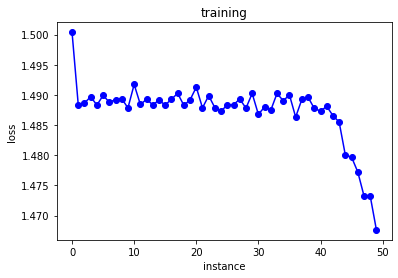

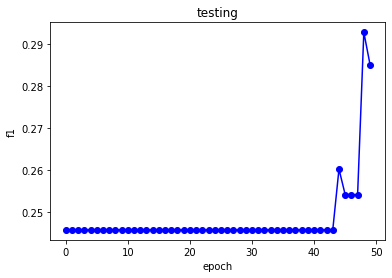

(GRU_classifier(
   (rnn): GRU(200, 64)
   (fc): Linear(in_features=64, out_features=5, bias=True)
   (tanh): Tanh()
   (softmax): Softmax(dim=1)
 ),
 [0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804024497,
  0.2457567804

In [89]:
hidden_size = 64
#category_list = ['Surgery', 'Consult - History and Phy.']
output_size = 5
rnn = GRU_classifier(200, hidden_size, output_size, category_list)
train_rnn(rnn, train_loader, test_loader, epochs=50,  learning_rate=0.01)

### Top 5 classification with raw features

In [68]:
selected_label = [' Surgery',
                  ' Consult - History and Phy.',
                  ' Cardiovascular / Pulmonary',
                  ' Orthopedic',
                  ' Radiology']
top5_raw = data[data['medical_specialty'].isin(selected_label)]
top5_raw.head(5)

transcription  \
3   2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4   1.  The left ventricular cavity size and wall ...   
7   2-D ECHOCARDIOGRAM,Multiple views of the heart...   
9   DESCRIPTION:,1.  Normal cardiac chambers size....   
11  2-D STUDY,1. Mild aortic stenosis, widely calc...   

              medical_specialty  \
3    Cardiovascular / Pulmonary   
4    Cardiovascular / Pulmonary   
7    Cardiovascular / Pulmonary   
9    Cardiovascular / Pulmonary   
11   Cardiovascular / Pulmonary   

                                  transcription_clear SUBJECTIVE MEDICATIONS  \
3   d m mode left atrial enlargement with left atr...        NaN         NaN   
4   the left ventricular cavity size and wall thic...        NaN         NaN   
7   d echocardiogram multiple views of the heart a...        NaN         NaN   
9   description normal cardiac chambers size norma...        NaN         NaN   
11  d study mild aortic stenosis widely calcified ...        NaN         NaN   

   ALLERGIES OBJECTIVE HEENT ASSESSMENT PLAN  ... SEROLOGY EVIDENCE COLLECTED  \
3        NaN       NaN   NaN        NaN  NaN  ...      NaN                NaN   
4        NaN       NaN   NaN        NaN  NaN  ...      NaN                NaN   
7        NaN       NaN   NaN        NaN  NaN  ...      NaN                NaN   
9        NaN       NaN   NaN        NaN  NaN  ...      NaN                NaN   
11       NaN       NaN   NaN        NaN  NaN  ...      NaN                NaN   

   CLINOCOPATHOLIGICAL CORRELATION EXTERNAL EVIDENCE OF INJURY  \
3                              NaN                         NaN   
4                              NaN                         NaN   
7                              NaN                         NaN   
9                              NaN                         NaN   
11                             NaN                         NaN   

   REMAINDER OF EXTERNAL EXAMINATION INTERNAL EXAM MEDIASTINUM  \
3                                NaN           NaN         NaN   
4                                NaN           NaN         NaN   
7                                NaN           NaN         NaN   
9                                NaN           NaN         NaN   
11                               NaN           NaN         NaN   

   AORTA AND VENA CAVA SPLEEN ADRENALS  
3                  NaN    NaN      NaN  
4                  NaN    NaN      NaN  
7                  NaN    NaN      NaN  
9                  NaN    NaN      NaN  
11                 NaN    NaN      NaN  

[5 rows x 1760 columns]

In [74]:
category_list = selected_label
train_loader, test_loader = prepare_data(top5_raw, 'transcription_clear', 'medical_specialty', bio_wordvec,
                 test_size = 0.2, seed = 1234, batch_size = 32)



  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

  2%|█▋                                                                                 | 1/50 [00:25<20:26, 25.03s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





  4%|███▎                                                                               | 2/50 [00:51<20:18, 25.39s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





  6%|████▉                                                                              | 3/50 [01:19<20:39, 26.36s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





  8%|██████▋                                                                            | 4/50 [01:43<19:29, 25.41s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 10%|████████▎                                                                          | 5/50 [02:05<18:29, 24.66s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 12%|█████████▉                                                                         | 6/50 [02:29<17:44, 24.18s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 14%|███████████▌                                                                       | 7/50 [02:52<17:16, 24.10s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 16%|█████████████▎                                                                     | 8/50 [03:18<17:09, 24.51s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 18%|██████████████▉                                                                    | 9/50 [03:42<16:42, 24.45s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 20%|████████████████▍                                                                 | 10/50 [04:06<16:04, 24.12s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 22%|██████████████████                                                                | 11/50 [04:29<15:29, 23.83s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 24%|███████████████████▋                                                              | 12/50 [04:53<15:08, 23.91s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 26%|█████████████████████▎                                                            | 13/50 [05:17<14:52, 24.12s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 28%|██████████████████████▉                                                           | 14/50 [05:41<14:22, 23.95s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 30%|████████████████████████▌                                                         | 15/50 [06:04<13:48, 23.68s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 32%|██████████████████████████▏                                                       | 16/50 [06:26<13:12, 23.30s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 34%|███████████████████████████▉                                                      | 17/50 [06:51<13:00, 23.65s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 36%|█████████████████████████████▌                                                    | 18/50 [07:16<12:45, 23.93s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 38%|███████████████████████████████▏                                                  | 19/50 [07:42<12:48, 24.79s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 40%|████████████████████████████████▊                                                 | 20/50 [08:07<12:24, 24.81s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 42%|██████████████████████████████████▍                                               | 21/50 [08:32<12:01, 24.87s/it]

              precision    recall  f1-score   support

           0       0.42      1.00      0.59       218
           1       0.00      0.00      0.00       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.42       521
   macro avg       0.08      0.20      0.12       521
weighted avg       0.18      0.42      0.25       521





 44%|████████████████████████████████████                                              | 22/50 [08:57<11:36, 24.86s/it]

              precision    recall  f1-score   support

           0       0.43      1.00      0.60       218
           1       0.45      0.05      0.09       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.43       521
   macro avg       0.18      0.21      0.14       521
weighted avg       0.27      0.43      0.27       521





 46%|█████████████████████████████████████▋                                            | 23/50 [09:24<11:28, 25.51s/it]

              precision    recall  f1-score   support

           0       0.54      1.00      0.70       218
           1       0.68      0.81      0.74       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.58       521
   macro avg       0.24      0.36      0.29       521
weighted avg       0.36      0.58      0.44       521





 48%|███████████████████████████████████████▎                                          | 24/50 [09:55<11:42, 27.02s/it]

              precision    recall  f1-score   support

           0       0.57      1.00      0.72       218
           1       0.70      0.93      0.80       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.60       521
   macro avg       0.25      0.39      0.30       521
weighted avg       0.37      0.60      0.46       521





 50%|█████████████████████████████████████████                                         | 25/50 [10:24<11:34, 27.79s/it]

              precision    recall  f1-score   support

           0       0.61      0.98      0.75       218
           1       0.59      0.99      0.74       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.61       521
   macro avg       0.24      0.39      0.30       521
weighted avg       0.37      0.61      0.46       521





 52%|██████████████████████████████████████████▋                                       | 26/50 [10:50<10:55, 27.32s/it]

              precision    recall  f1-score   support

           0       0.63      0.98      0.76       218
           1       0.56      0.99      0.72       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.60       521
   macro avg       0.24      0.39      0.30       521
weighted avg       0.37      0.60      0.46       521





 54%|████████████████████████████████████████████▎                                     | 27/50 [11:18<10:28, 27.33s/it]

              precision    recall  f1-score   support

           0       0.59      0.99      0.74       218
           1       0.64      0.98      0.77       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.61       521
   macro avg       0.25      0.39      0.30       521
weighted avg       0.37      0.61      0.46       521





 56%|█████████████████████████████████████████████▉                                    | 28/50 [11:43<09:48, 26.76s/it]

              precision    recall  f1-score   support

           0       0.64      0.97      0.77       218
           1       0.53      0.99      0.69       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.60       521
   macro avg       0.23      0.39      0.29       521
weighted avg       0.37      0.60      0.46       521





 58%|███████████████████████████████████████████████▌                                  | 29/50 [12:09<09:15, 26.43s/it]

              precision    recall  f1-score   support

           0       0.59      0.99      0.74       218
           1       0.66      0.97      0.78       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.61       521
   macro avg       0.25      0.39      0.30       521
weighted avg       0.37      0.61      0.46       521





 60%|█████████████████████████████████████████████████▏                                | 30/50 [12:33<08:34, 25.70s/it]

              precision    recall  f1-score   support

           0       0.66      0.99      0.79       218
           1       0.52      0.99      0.68       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.61       521
   macro avg       0.24      0.40      0.30       521
weighted avg       0.38      0.61      0.47       521





 62%|██████████████████████████████████████████████████▊                               | 31/50 [12:58<08:04, 25.50s/it]

              precision    recall  f1-score   support

           0       0.64      0.99      0.77       218
           1       0.56      0.99      0.71       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.61       521
   macro avg       0.24      0.40      0.30       521
weighted avg       0.38      0.61      0.46       521





 64%|████████████████████████████████████████████████████▍                             | 32/50 [13:22<07:33, 25.20s/it]

              precision    recall  f1-score   support

           0       0.66      0.97      0.79       218
           1       0.58      0.99      0.73       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.44      0.20      0.28        55

    accuracy                           0.62       521
   macro avg       0.34      0.43      0.36       521
weighted avg       0.44      0.62      0.50       521





 66%|██████████████████████████████████████████████████████                            | 33/50 [13:47<07:03, 24.90s/it]

              precision    recall  f1-score   support

           0       0.60      0.99      0.75       218
           1       0.63      0.99      0.77       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.61       521
   macro avg       0.25      0.40      0.30       521
weighted avg       0.38      0.61      0.46       521





 68%|███████████████████████████████████████████████████████▊                          | 34/50 [14:10<06:33, 24.59s/it]

              precision    recall  f1-score   support

           0       0.57      0.99      0.73       218
           1       0.68      0.94      0.79       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00        55

    accuracy                           0.60       521
   macro avg       0.25      0.39      0.30       521
weighted avg       0.37      0.60      0.46       521





 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [14:34<06:04, 24.32s/it]

              precision    recall  f1-score   support

           0       0.60      0.99      0.74       218
           1       0.69      0.94      0.80       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.59      0.18      0.28        55

    accuracy                           0.62       521
   macro avg       0.37      0.42      0.36       521
weighted avg       0.45      0.62      0.50       521





 72%|███████████████████████████████████████████████████████████                       | 36/50 [14:59<05:42, 24.44s/it]

              precision    recall  f1-score   support

           0       0.66      0.98      0.79       218
           1       0.61      0.98      0.75       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.44      0.27      0.34        55

    accuracy                           0.63       521
   macro avg       0.34      0.45      0.38       521
weighted avg       0.45      0.63      0.52       521





 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [15:24<05:18, 24.52s/it]

              precision    recall  f1-score   support

           0       0.64      0.99      0.78       218
           1       0.65      0.96      0.78       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.53      0.29      0.38        55

    accuracy                           0.64       521
   macro avg       0.36      0.45      0.39       521
weighted avg       0.45      0.64      0.52       521





 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [15:47<04:50, 24.23s/it]

              precision    recall  f1-score   support

           0       0.71      0.97      0.82       218
           1       0.66      0.97      0.79       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.51      0.67      0.58        55

    accuracy                           0.67       521
   macro avg       0.38      0.52      0.44       521
weighted avg       0.48      0.67      0.56       521





 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [16:11<04:26, 24.18s/it]

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       218
           1       0.58      0.99      0.73       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.53      0.44      0.48        55

    accuracy                           0.65       521
   macro avg       0.37      0.48      0.41       521
weighted avg       0.47      0.65      0.54       521





 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [16:34<03:59, 23.90s/it]

              precision    recall  f1-score   support

           0       0.73      0.95      0.83       218
           1       0.67      0.97      0.79       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.45      0.73      0.56        55

    accuracy                           0.67       521
   macro avg       0.37      0.53      0.43       521
weighted avg       0.49      0.67      0.56       521





 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [16:58<03:35, 23.94s/it]

              precision    recall  f1-score   support

           0       0.73      0.95      0.83       218
           1       0.64      0.99      0.78       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.49      0.67      0.56        55

    accuracy                           0.67       521
   macro avg       0.37      0.52      0.43       521
weighted avg       0.48      0.67      0.56       521





 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [17:23<03:12, 24.09s/it]

              precision    recall  f1-score   support

           0       0.71      0.98      0.82       218
           1       0.65      0.99      0.79       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.53      0.64      0.58        55

    accuracy                           0.67       521
   macro avg       0.38      0.52      0.44       521
weighted avg       0.48      0.67      0.56       521





 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [17:48<02:49, 24.27s/it]

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       218
           1       0.68      0.99      0.81       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.49      0.73      0.59        55

    accuracy                           0.68       521
   macro avg       0.38      0.54      0.45       521
weighted avg       0.49      0.68      0.57       521





 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [18:11<02:24, 24.08s/it]

              precision    recall  f1-score   support

           0       0.69      0.98      0.81       218
           1       0.66      0.99      0.79       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.56      0.56      0.56        55

    accuracy                           0.67       521
   macro avg       0.38      0.51      0.43       521
weighted avg       0.48      0.67      0.55       521





 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [18:35<02:00, 24.02s/it]

              precision    recall  f1-score   support

           0       0.72      0.96      0.83       218
           1       0.66      0.99      0.79       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.51      0.71      0.60        55

    accuracy                           0.67       521
   macro avg       0.38      0.53      0.44       521
weighted avg       0.49      0.67      0.57       521





 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [19:00<01:37, 24.27s/it]

              precision    recall  f1-score   support

           0       0.68      0.99      0.80       218
           1       0.68      0.99      0.81       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.59      0.58      0.59        55

    accuracy                           0.67       521
   macro avg       0.39      0.51      0.44       521
weighted avg       0.48      0.67      0.56       521





 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [19:23<01:12, 24.04s/it]

              precision    recall  f1-score   support

           0       0.72      0.97      0.82       218
           1       0.70      0.98      0.81       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.51      0.75      0.61        55

    accuracy                           0.68       521
   macro avg       0.39      0.54      0.45       521
weighted avg       0.49      0.68      0.57       521





 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [19:48<00:48, 24.21s/it]

              precision    recall  f1-score   support

           0       0.73      0.96      0.83       218
           1       0.72      0.96      0.82       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.50      0.87      0.64        55

    accuracy                           0.69       521
   macro avg       0.39      0.56      0.46       521
weighted avg       0.50      0.69      0.58       521





 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [20:11<00:23, 23.96s/it]

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       218
           1       0.69      0.98      0.81       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.52      0.73      0.61        55

    accuracy                           0.68       521
   macro avg       0.39      0.54      0.45       521
weighted avg       0.49      0.68      0.57       521





100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [20:35<00:00, 24.71s/it]

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       218
           1       0.68      0.98      0.80       103
           2       0.00      0.00      0.00        74
           3       0.00      0.00      0.00        71
           4       0.54      0.76      0.63        55

    accuracy                           0.68       521
   macro avg       0.39      0.54      0.45       521
weighted avg       0.49      0.68      0.57       521



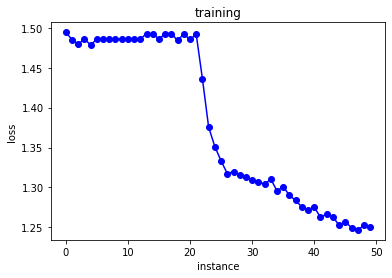

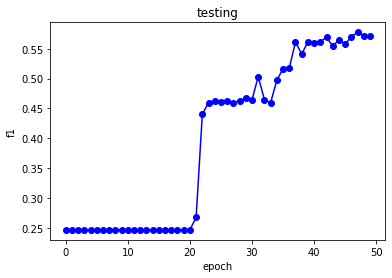

(GRU_classifier(
   (rnn): GRU(200, 64)
   (fc): Linear(in_features=64, out_features=5, bias=True)
   (tanh): Tanh()
   (softmax): Softmax(dim=1)
 ),
 [0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.24686573909339538,
  0.2679376723219536,
  0.4401786725924635,
  0.4598134178458242,
  0.46250401526153284,
  0.4615263351955287,
  0.46321912620145467,
  0.45964938383364484,
  0.46299506635078896,
  0.4668450614432514,
  0.464617377678867,
  0.5032546534428934,
  0.4645558955725363,
  0.4598315486967704,
  0.4976279531710279,
  0.5162357761729189,
  0.5177726530192776,
  0.56118780

In [75]:
hidden_size = 64
#category_list = ['Surgery', 'Consult - History and Phy.']
output_size = 5
rnn = GRU_classifier(200, hidden_size, output_size, category_list)
train_rnn(rnn, train_loader, test_loader, epochs=50,  learning_rate=0.01)

In [76]:
bow_vect=CountVectorizer(max_df = 98, min_df = 4, ngram_range = (1,1), binary = True)

In [77]:
def average_vectors(words, w2v):
    p = len(w2v['the'])
    vectors_sum=np.zeros(p)
    for word in words:
        if word in w2v:                            # some words are missing in w2v keys
            temp=w2v[word]
        else:
            temp = [0]*p
        vectors_sum+=temp
    vectors_average=(vectors_sum+[1]*p)/(len(words)+1) # some sample has no word in feature 
    return vectors_average

def max_vectors(words, w2v): 
    p = len(w2v['the'])
    temp=np.zeros((len(words),p))
    for index, word in enumerate(words):
        if word in w2v:
            temp[index]=w2v[word]
        else:
            temp[index]=[0]*p   
    vectors_max=np.array([max(idx) for idx in zip(*temp)])
    return vectors_max

def min_vectors(words, w2v):
    # YOUR CODE HERE
    p = len(w2v['the'])
    temp=np.zeros((len(words),p))
    for index, word in enumerate(words):
        if word in w2v:
            temp[index]=w2v[word]
        else:
            temp[index]=[0]*p 
    vectors_min=np.array([min(idx) for idx in zip(*temp)])
    return vectors_min

def min_max_vectors(words, w2v):
    # YOUR CODE HERE
    p = len(w2v['the'])
    temp=np.zeros((len(words), p))
    for index, word in enumerate(words):
        if word in w2v:
            temp=w2v[word]
        else:
            temp = [0]*p
    vectors_min=np.array([min(idx) for idx in zip(*temp)])
    vectors_max=np.array([max(idx) for idx in zip(*temp)])
    vectors_min_max=np.concatenate((vectors_min,vectors_max))
    return vectors_min_max
def make_word_vector_features(X, vocab, w2v, aggregation_fn):
    """
    a numpy.ndarray with n rows and d columns, where n is the number of documents
    in X and d is the word vector dimension resulting from aggregation_fn
    """
    # YOUR CODE HERE
    mylist=[]
    for i in range(X.shape[0]):
        words=vocab[X[i].indices]
        temp=aggregation_fn(words, w2v)
        mylist.append(temp)
    fn=np.array(mylist)
    return fn

In [79]:
bow_x= bow_vect.fit_transform(top5_raw['transcription_clear'].tolist())
vocab = np.array(bow_vect.get_feature_names())
w2v_vec = make_word_vector_features(bow_x, vocab, bio_wordvec, average_vectors)

In [80]:
labels= top5_raw['medical_specialty'].tolist()
x_train, x_test, y_train, y_test = train_test_split(w2v_vec, labels, 
                                                    stratify=labels, test_size = 0.2,random_state=1234) 
print('Train Set Size:'+str(x_train.shape))
print('Test Set Size:'+str(x_test.shape))
logreg = LogisticRegression(penalty= 'l2', C = 0.1, solver= 'lbfgs')
w2v_model = logreg.fit(x_train, y_train)
y_test_pred = w2v_model.predict(x_test)

Train Set Size:(2082, 200)
Test Set Size:(521, 200)


In [81]:
print('results on training data')
print(classification_report(y_train, w2v_model.predict(x_train)))
print('results on testing data')
print(classification_report(y_test, y_test_pred))

results on training data
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.55      0.40      0.47       297
 Consult - History and Phy.       0.70      0.90      0.79       413
                 Orthopedic       0.54      0.31      0.39       284
                  Radiology       0.68      0.48      0.56       218
                    Surgery       0.75      0.87      0.81       870

                   accuracy                           0.69      2082
                  macro avg       0.64      0.59      0.60      2082
               weighted avg       0.67      0.69      0.67      2082

results on testing data
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.51      0.36      0.43        74
 Consult - History and Phy.       0.75      0.91      0.82       103
                 Orthopedic       0.38      0.24      0.29        71
                  Radiology       0.67      0.58  

### T5 + Logistic regression

In [85]:
bow_x= bow_vect.fit_transform(top5_t5['transcription_clear'].tolist())
vocab = np.array(bow_vect.get_feature_names())
w2v_vec = make_word_vector_features(bow_x, vocab, bio_wordvec, average_vectors)

In [86]:
labels= top5_t5['medical_specialty'].tolist()
x_train, x_test, y_train, y_test = train_test_split(w2v_vec, labels, 
                                                    stratify=labels, test_size = 0.2,random_state=1234) 
print('Train Set Size:'+str(x_train.shape))
print('Test Set Size:'+str(x_test.shape))
logreg = LogisticRegression(penalty= 'l2', C = 0.1, solver= 'lbfgs')
w2v_model = logreg.fit(x_train, y_train)
y_test_pred = w2v_model.predict(x_test)

Train Set Size:(2032, 200)
Test Set Size:(508, 200)


In [87]:
print('results on training data')
print(classification_report(y_train, w2v_model.predict(x_train)))
print('results on testing data')
print(classification_report(y_test, y_test_pred))

results on training data
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.55      0.41      0.47       288
 Consult - History and Phy.       0.71      0.91      0.80       408
                 Orthopedic       0.54      0.35      0.42       282
                  Radiology       0.74      0.50      0.60       209
                    Surgery       0.75      0.87      0.81       845

                   accuracy                           0.70      2032
                  macro avg       0.66      0.61      0.62      2032
               weighted avg       0.69      0.70      0.68      2032

results on testing data
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.48      0.40      0.44        72
 Consult - History and Phy.       0.69      0.88      0.78       102
                 Orthopedic       0.35      0.24      0.29        70
                  Radiology       0.65      0.33  

## Auto-fill Table
As we talked about previously, each transctiption contains a different list of record, with length ranging from five to ten. For instnace, second patients has "PAST MEDICAL HISTORY", "PAST SURGICAL HISTORY","SOCIAL HISTORY", "FAMILY HISTORY","CURRENT MEDICATIONS", "ALLERGIES","MISCELLANEOUS/EATING HISTORY","REVIEW OF SYSTEMS","PHYSICAL EXAMINATION". It would be helpful to have a auto-fill table approach to extract the whole paragraph into corresponding information. We extracted all the upper case keywords following a ':' for each patient, and we found out it formed 1700 different keywords in total. 

In [54]:
regex = r"\b([A-Z]+(?:[^\S\r\n]+[A-Z]+)*):"
for index,data_row in data.iterrows():
    temp_split=re.split(regex, data_row['transcription'])
    for odd, t in enumerate(temp_split):
        if (odd % 2) != 0:
#            translator_c = str.maketrans(string.punctuation, ' '*len(string.punctuation))
#             temp_modify=temp_split[odd+1].apply(lambda x: ' '.join([i for i in str(x).lower().
#                                             translate(translator_c).split(' ') if i.isalpha()]))
            data.at[index,t]=temp_split[odd+1]
print(data.shape)
data.head()

(4966, 1760)


transcription  \
0  SUBJECTIVE:,  This 23-year-old white female pr...   
1  PAST MEDICAL HISTORY:, He has difficulty climb...   
2  HISTORY OF PRESENT ILLNESS: , I have seen ABC ...   
3  2-D M-MODE: , ,1.  Left atrial enlargement wit...   
4  1.  The left ventricular cavity size and wall ...   

             medical_specialty  \
0         Allergy / Immunology   
1                   Bariatrics   
2                   Bariatrics   
3   Cardiovascular / Pulmonary   
4   Cardiovascular / Pulmonary   

                                 transcription_clear  \
0  subjective this year old white female presents...   
1  past medical history he has difficulty climbin...   
2  history of present illness i have seen abc tod...   
3  d m mode left atrial enlargement with left atr...   
4  the left ventricular cavity size and wall thic...   

                                          SUBJECTIVE  \
0  ,  This 23-year-old white female presents with...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         MEDICATIONS  \
0   , Her only medication currently is Ortho Tri-...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                         ALLERGIES  \
0          , She has no known medicine allergies.,   
1  ,  He is allergic to Penicillin.,MISCELLANEOUS/   
2                                              NaN   
3                                              NaN   
4                                              NaN   

                                           OBJECTIVE  \
0  ,Vitals:  Weight was 130 pounds and blood pres...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                               HEENT              ASSESSMENT  \
0    Her throat was mildly erythematous without e...  ,  Allergic rhinitis.,   
1                                                NaN                     NaN   
2                                                NaN                     NaN   
3                                                NaN                     NaN   
4                                                NaN                     NaN   

                                                PLAN  ... SEROLOGY  \
0  ,1.  She will try Zyrtec instead of Allegra ag...  ...      NaN   
1                                                NaN  ...      NaN   
2  ,  I have explained to him the risks and poten...  ...      NaN   
3                                                NaN  ...      NaN   
4                                                NaN  ...      NaN   

  EVIDENCE COLLECTED CLINOCOPATHOLIGICAL CORRELATION  \
0                NaN                             NaN   
1                NaN                             NaN   
2                NaN                             NaN   
3                NaN                             NaN   
4                NaN                             NaN   

  EXTERNAL EVIDENCE OF INJURY REMAINDER OF EXTERNAL EXAMINATION INTERNAL EXAM  \
0                         NaN                               NaN           NaN   
1                         NaN                               NaN           NaN   
2                         NaN                               NaN           NaN   
3                         NaN                               NaN           NaN   
4                         NaN                               NaN           NaN   

  MEDIASTINUM AORTA AND VENA CAVA SPLEEN ADRENALS  
0         NaN                 NaN    NaN      

The new 1757 keywords are too large, we sort them based on the number of patients, and further analyzing on the keywords have more than 200 records.

## Use a lite version of the data set
With the sequential modeling, we didn't see any paid-off, especially we have spent so much time to find a good embedding or summerization stragtegy. There are two reasons
- appearance of the keywords in the paragraph is a disturbance since it breaks down the whole paragraph.
- the order of the keywords/items are different.
- after trimming some special characters (numbers, ) off,  the sentence does not make any sense, which will mislead the RNN
- many characters are padded with mean_vec, such as abbreviations, units

Now we turn to a simple application -- using the history to predict if the patients need surgery or just medicine. If this works, we might further design the automatic diagnosis systems by adding a series of those simple classifiers.

In [57]:
selected_columns = ['SUBJECTIVE',
                'PAST SURGICAL HISTORY',
                #'INDICATIONS',
                'HISTORY',
                 'FAMILY HISTORY',
                 'SOCIAL HISTORY',
                 'PAST MEDICAL HISTORY',
                 'ALLERGIES',
                 #'REASON FOR CONSULTATION',
                 'HISTORY OF PRESENT ILLNESS', 
                 'CURRENT MEDICATIONS']
binary_label = [' Surgery',
                ' General Medicine']
              
lite_data = data[selected_columns + ['medical_specialty']]
binary_data = lite_data[lite_data['medical_specialty'].isin(binary_label)]  
binary_data.head(5)

SUBJECTIVE PAST SURGICAL HISTORY  \
19         NaN                   NaN   
174        NaN                   NaN   
177        NaN                   NaN   
179        NaN                   NaN   
181        NaN                   NaN   

                                               HISTORY        FAMILY HISTORY  \
19                                                 NaN   , Noncontributory.,   
174   , This 51-year-old male presents to ABCD Gene...                   NaN   
177                                                NaN                   NaN   
179                                                NaN                   NaN   
181                                                NaN                   NaN   

                                        SOCIAL HISTORY  \
19    , Negative for illicit drugs, alcohol, and to...   
174                                                NaN   
177                                                NaN   
179                                                NaN   
181                                                NaN   

                                  PAST MEDICAL HISTORY  \
19    , Significant for diabetes, hypertension, ast...   
174                                                NaN   
177                                                NaN   
179                                                NaN   
181                                                NaN   

                        ALLERGIES  \
19     ,No known drug allergies.,   
174                           NaN   
177                           NaN   
179                           NaN   
181                           NaN   

                            HISTORY OF PRESENT ILLNESS  \
19   ,  The patient is a 17-year-old female, who pr...   
174                                                NaN   
177                                                NaN   
179                                                NaN   
181                                                NaN   

                                   CURRENT MEDICATIONS  medical_specialty  
19    , Prevacid, Humulin, Diprivan, Proventil, Una...   General Medicine  
174                                                NaN            Surgery  
177                                                NaN            Surgery  
179                                                NaN            Surgery  
181                                                NaN            Surgery

In [58]:
binary_data['combined_feature'] = binary_data['SUBJECTIVE']
for column in selected_columns:
    if column != 'SUBJECTIVE':
        binary_data['combined_feature'].update(binary_data.pop(column))
binary_data.head(5)

SUBJECTIVE  medical_specialty  \
19         NaN   General Medicine   
174        NaN            Surgery   
177        NaN            Surgery   
179        NaN            Surgery   
181        NaN            Surgery   

                                      combined_feature  
19    , Prevacid, Humulin, Diprivan, Proventil, Una...  
174   , This 51-year-old male presents to ABCD Gene...  
177                                                NaN  
179                                                NaN  
181                                                NaN

In [60]:
binary_data = binary_data.drop(binary_data[binary_data['combined_feature'].isna()].index)
binary_data.pop('SUBJECTIVE')
print(binary_data.shape)

(302, 2)


In [61]:
binary_data['feature_clear']=binary_data['combined_feature'].apply(lambda x: ' '.join([i for i in str(x).lower().translate(translator_c).split(' ') if i.isalpha()]))

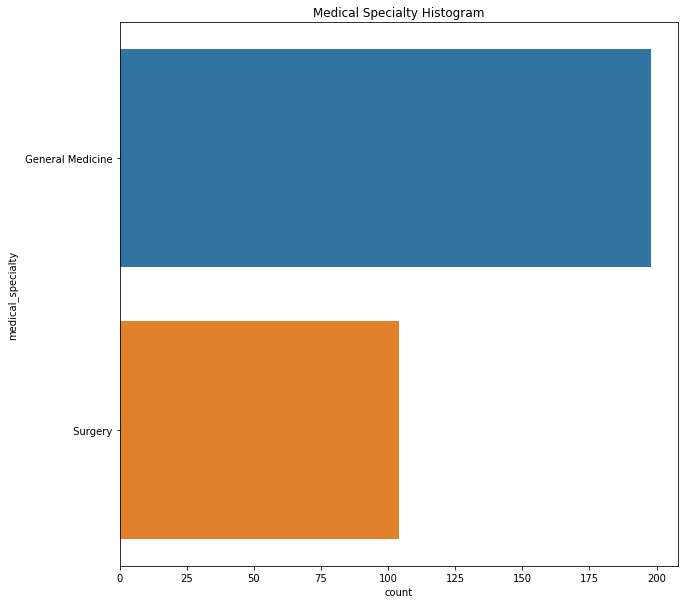

In [62]:
fig = plt.figure(figsize=(10, 10)) 
plt.title('Medical Specialty Histogram')
plt.xlabel('Specialty Category')
plt.ylabel('Counts')
#plt.hist(data['medical_specialty'], edgecolor = 'black', bins = 20)
sns.countplot(y='medical_specialty', data = binary_data)
plt.show()

In [82]:
category_list = [' Surgery',
                ' General Medicine']
train_loader, test_loader = prepare_data(binary_data, 'feature_clear', 'medical_specialty', bio_wordvec,
                 test_size = 0.2, seed = 1234, batch_size = 64)



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  1%|▊                                                                                 | 1/100 [00:00<01:32,  1.07it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





  2%|█▋                                                                                | 2/100 [00:01<01:33,  1.05it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





  3%|██▍                                                                               | 3/100 [00:02<01:32,  1.05it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





  4%|███▎                                                                              | 4/100 [00:03<01:31,  1.05it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





  5%|████                                                                              | 5/100 [00:04<01:30,  1.05it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





  6%|████▉                                                                             | 6/100 [00:05<01:31,  1.03it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





  7%|█████▋                                                                            | 7/100 [00:06<01:33,  1.01s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





  8%|██████▌                                                                           | 8/100 [00:08<01:35,  1.04s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





  9%|███████▍                                                                          | 9/100 [00:09<01:35,  1.05s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





 10%|████████                                                                         | 10/100 [00:10<01:34,  1.05s/it]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.66      1.00      0.79        40

    accuracy                           0.66        61
   macro avg       0.33      0.50      0.40        61
weighted avg       0.43      0.66      0.52        61





 11%|████████▉                                                                        | 11/100 [00:11<01:35,  1.07s/it]

              precision    recall  f1-score   support

           0       0.50      0.05      0.09        21
           1       0.66      0.97      0.79        40

    accuracy                           0.66        61
   macro avg       0.58      0.51      0.44        61
weighted avg       0.61      0.66      0.55        61





 12%|█████████▋                                                                       | 12/100 [00:12<01:40,  1.14s/it]

              precision    recall  f1-score   support

           0       0.40      0.10      0.15        21
           1       0.66      0.93      0.77        40

    accuracy                           0.64        61
   macro avg       0.53      0.51      0.46        61
weighted avg       0.57      0.64      0.56        61





 13%|██████████▌                                                                      | 13/100 [00:13<01:42,  1.18s/it]

              precision    recall  f1-score   support

           0       1.00      0.05      0.09        21
           1       0.67      1.00      0.80        40

    accuracy                           0.67        61
   macro avg       0.83      0.52      0.45        61
weighted avg       0.78      0.67      0.56        61





 14%|███████████▎                                                                     | 14/100 [00:15<01:41,  1.18s/it]

              precision    recall  f1-score   support

           0       0.50      0.10      0.16        21
           1       0.67      0.95      0.78        40

    accuracy                           0.66        61
   macro avg       0.58      0.52      0.47        61
weighted avg       0.61      0.66      0.57        61





 15%|████████████▏                                                                    | 15/100 [00:16<01:41,  1.19s/it]

              precision    recall  f1-score   support

           0       0.60      0.14      0.23        21
           1       0.68      0.95      0.79        40

    accuracy                           0.67        61
   macro avg       0.64      0.55      0.51        61
weighted avg       0.65      0.67      0.60        61





 16%|████████████▉                                                                    | 16/100 [00:17<01:39,  1.18s/it]

              precision    recall  f1-score   support

           0       1.00      0.05      0.09        21
           1       0.67      1.00      0.80        40

    accuracy                           0.67        61
   macro avg       0.83      0.52      0.45        61
weighted avg       0.78      0.67      0.56        61





 17%|█████████████▊                                                                   | 17/100 [00:18<01:36,  1.17s/it]

              precision    recall  f1-score   support

           0       0.70      0.33      0.45        21
           1       0.73      0.93      0.81        40

    accuracy                           0.72        61
   macro avg       0.71      0.63      0.63        61
weighted avg       0.72      0.72      0.69        61





 18%|██████████████▌                                                                  | 18/100 [00:19<01:37,  1.19s/it]

              precision    recall  f1-score   support

           0       0.50      0.10      0.16        21
           1       0.67      0.95      0.78        40

    accuracy                           0.66        61
   macro avg       0.58      0.52      0.47        61
weighted avg       0.61      0.66      0.57        61





 19%|███████████████▍                                                                 | 19/100 [00:20<01:36,  1.19s/it]

              precision    recall  f1-score   support

           0       0.67      0.29      0.40        21
           1       0.71      0.93      0.80        40

    accuracy                           0.70        61
   macro avg       0.69      0.61      0.60        61
weighted avg       0.70      0.70      0.67        61





 20%|████████████████▏                                                                | 20/100 [00:22<01:32,  1.15s/it]

              precision    recall  f1-score   support

           0       0.75      0.29      0.41        21
           1       0.72      0.95      0.82        40

    accuracy                           0.72        61
   macro avg       0.73      0.62      0.62        61
weighted avg       0.73      0.72      0.68        61





 21%|█████████████████                                                                | 21/100 [00:23<01:29,  1.13s/it]

              precision    recall  f1-score   support

           0       0.80      0.38      0.52        21
           1       0.75      0.95      0.84        40

    accuracy                           0.75        61
   macro avg       0.77      0.67      0.68        61
weighted avg       0.76      0.75      0.73        61





 22%|█████████████████▊                                                               | 22/100 [00:24<01:31,  1.18s/it]

              precision    recall  f1-score   support

           0       0.76      0.62      0.68        21
           1       0.82      0.90      0.86        40

    accuracy                           0.80        61
   macro avg       0.79      0.76      0.77        61
weighted avg       0.80      0.80      0.80        61





 23%|██████████████████▋                                                              | 23/100 [00:25<01:29,  1.16s/it]

              precision    recall  f1-score   support

           0       1.00      0.24      0.38        21
           1       0.71      1.00      0.83        40

    accuracy                           0.74        61
   macro avg       0.86      0.62      0.61        61
weighted avg       0.81      0.74      0.68        61





 24%|███████████████████▍                                                             | 24/100 [00:26<01:27,  1.16s/it]

              precision    recall  f1-score   support

           0       0.71      0.48      0.57        21
           1       0.77      0.90      0.83        40

    accuracy                           0.75        61
   macro avg       0.74      0.69      0.70        61
weighted avg       0.75      0.75      0.74        61





 25%|████████████████████▎                                                            | 25/100 [00:27<01:24,  1.13s/it]

              precision    recall  f1-score   support

           0       0.87      0.62      0.72        21
           1       0.83      0.95      0.88        40

    accuracy                           0.84        61
   macro avg       0.85      0.78      0.80        61
weighted avg       0.84      0.84      0.83        61





 26%|█████████████████████                                                            | 26/100 [00:28<01:22,  1.11s/it]

              precision    recall  f1-score   support

           0       0.89      0.38      0.53        21
           1       0.75      0.97      0.85        40

    accuracy                           0.77        61
   macro avg       0.82      0.68      0.69        61
weighted avg       0.80      0.77      0.74        61





 27%|█████████████████████▊                                                           | 27/100 [00:29<01:19,  1.08s/it]

              precision    recall  f1-score   support

           0       0.69      0.52      0.59        21
           1       0.78      0.88      0.82        40

    accuracy                           0.75        61
   macro avg       0.73      0.70      0.71        61
weighted avg       0.75      0.75      0.74        61





 28%|██████████████████████▋                                                          | 28/100 [00:30<01:16,  1.07s/it]

              precision    recall  f1-score   support

           0       0.90      0.43      0.58        21
           1       0.76      0.97      0.86        40

    accuracy                           0.79        61
   macro avg       0.83      0.70      0.72        61
weighted avg       0.81      0.79      0.76        61





 29%|███████████████████████▍                                                         | 29/100 [00:31<01:15,  1.07s/it]

              precision    recall  f1-score   support

           0       0.92      0.57      0.71        21
           1       0.81      0.97      0.89        40

    accuracy                           0.84        61
   macro avg       0.87      0.77      0.80        61
weighted avg       0.85      0.84      0.82        61





 30%|████████████████████████▎                                                        | 30/100 [00:32<01:13,  1.05s/it]

              precision    recall  f1-score   support

           0       0.81      0.62      0.70        21
           1       0.82      0.93      0.87        40

    accuracy                           0.82        61
   macro avg       0.82      0.77      0.79        61
weighted avg       0.82      0.82      0.81        61





 31%|█████████████████████████                                                        | 31/100 [00:33<01:12,  1.04s/it]

              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.79      0.95      0.86        40

    accuracy                           0.80        61
   macro avg       0.82      0.74      0.76        61
weighted avg       0.81      0.80      0.79        61





 32%|█████████████████████████▉                                                       | 32/100 [00:35<01:11,  1.05s/it]

              precision    recall  f1-score   support

           0       0.78      0.67      0.72        21
           1       0.84      0.90      0.87        40

    accuracy                           0.82        61
   macro avg       0.81      0.78      0.79        61
weighted avg       0.82      0.82      0.82        61





 33%|██████████████████████████▋                                                      | 33/100 [00:36<01:09,  1.04s/it]

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        21
           1       0.88      0.90      0.89        40

    accuracy                           0.85        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.85      0.85      0.85        61





 34%|███████████████████████████▌                                                     | 34/100 [00:37<01:08,  1.03s/it]

              precision    recall  f1-score   support

           0       0.72      0.62      0.67        21
           1       0.81      0.88      0.84        40

    accuracy                           0.79        61
   macro avg       0.77      0.75      0.76        61
weighted avg       0.78      0.79      0.78        61





 35%|████████████████████████████▎                                                    | 35/100 [00:38<01:08,  1.05s/it]

              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.79      0.95      0.86        40

    accuracy                           0.80        61
   macro avg       0.82      0.74      0.76        61
weighted avg       0.81      0.80      0.79        61





 36%|█████████████████████████████▏                                                   | 36/100 [00:39<01:06,  1.04s/it]

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.92      0.90      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.88      0.87        61
weighted avg       0.89      0.89      0.89        61





 37%|█████████████████████████████▉                                                   | 37/100 [00:40<01:05,  1.05s/it]

              precision    recall  f1-score   support

           0       0.82      0.43      0.56        21
           1       0.76      0.95      0.84        40

    accuracy                           0.77        61
   macro avg       0.79      0.69      0.70        61
weighted avg       0.78      0.77      0.75        61





 38%|██████████████████████████████▊                                                  | 38/100 [00:41<01:05,  1.06s/it]

              precision    recall  f1-score   support

           0       0.88      0.71      0.79        21
           1       0.86      0.95      0.90        40

    accuracy                           0.87        61
   macro avg       0.87      0.83      0.85        61
weighted avg       0.87      0.87      0.87        61





 39%|███████████████████████████████▌                                                 | 39/100 [00:42<01:04,  1.05s/it]

              precision    recall  f1-score   support

           0       0.74      0.81      0.77        21
           1       0.89      0.85      0.87        40

    accuracy                           0.84        61
   macro avg       0.82      0.83      0.82        61
weighted avg       0.84      0.84      0.84        61





 40%|████████████████████████████████▍                                                | 40/100 [00:43<01:03,  1.07s/it]

              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.79      0.95      0.86        40

    accuracy                           0.80        61
   macro avg       0.82      0.74      0.76        61
weighted avg       0.81      0.80      0.79        61





 41%|█████████████████████████████████▏                                               | 41/100 [00:44<01:02,  1.06s/it]

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.93      0.95      0.94        40

    accuracy                           0.92        61
   macro avg       0.91      0.90      0.91        61
weighted avg       0.92      0.92      0.92        61





 42%|██████████████████████████████████                                               | 42/100 [00:45<01:00,  1.04s/it]

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        21
           1       0.92      0.88      0.90        40

    accuracy                           0.87        61
   macro avg       0.85      0.87      0.86        61
weighted avg       0.87      0.87      0.87        61





 43%|██████████████████████████████████▊                                              | 43/100 [00:46<00:59,  1.05s/it]

              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.79      0.95      0.86        40

    accuracy                           0.80        61
   macro avg       0.82      0.74      0.76        61
weighted avg       0.81      0.80      0.79        61





 44%|███████████████████████████████████▋                                             | 44/100 [00:47<00:58,  1.05s/it]

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        21
           1       0.82      0.82      0.82        40

    accuracy                           0.77        61
   macro avg       0.75      0.75      0.75        61
weighted avg       0.77      0.77      0.77        61





 45%|████████████████████████████████████▍                                            | 45/100 [00:48<00:57,  1.05s/it]

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.86      0.93      0.89        40

    accuracy                           0.85        61
   macro avg       0.85      0.82      0.83        61
weighted avg       0.85      0.85      0.85        61





 46%|█████████████████████████████████████▎                                           | 46/100 [00:49<00:56,  1.05s/it]

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.90      0.90      0.90        40

    accuracy                           0.87        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.87      0.87      0.87        61





 47%|██████████████████████████████████████                                           | 47/100 [00:50<00:56,  1.07s/it]

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.86      0.93      0.89        40

    accuracy                           0.85        61
   macro avg       0.85      0.82      0.83        61
weighted avg       0.85      0.85      0.85        61





 48%|██████████████████████████████████████▉                                          | 48/100 [00:52<00:57,  1.10s/it]

              precision    recall  f1-score   support

           0       0.81      0.62      0.70        21
           1       0.82      0.93      0.87        40

    accuracy                           0.82        61
   macro avg       0.82      0.77      0.79        61
weighted avg       0.82      0.82      0.81        61





 49%|███████████████████████████████████████▋                                         | 49/100 [00:53<00:55,  1.09s/it]

              precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.88      0.95      0.92        40

    accuracy                           0.89        61
   macro avg       0.89      0.86      0.87        61
weighted avg       0.89      0.89      0.88        61





 50%|████████████████████████████████████████▌                                        | 50/100 [00:54<00:54,  1.08s/it]

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.93      0.95      0.94        40

    accuracy                           0.92        61
   macro avg       0.91      0.90      0.91        61
weighted avg       0.92      0.92      0.92        61





 51%|█████████████████████████████████████████▎                                       | 51/100 [00:55<00:52,  1.06s/it]

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.90      0.90      0.90        40

    accuracy                           0.87        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.87      0.87      0.87        61





 52%|██████████████████████████████████████████                                       | 52/100 [00:56<00:52,  1.09s/it]

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.90      0.88      0.89        40

    accuracy                           0.85        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.85      0.85      0.85        61





 53%|██████████████████████████████████████████▉                                      | 53/100 [00:57<00:50,  1.06s/it]

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.92      0.90      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.88      0.87        61
weighted avg       0.89      0.89      0.89        61





 54%|███████████████████████████████████████████▋                                     | 54/100 [00:58<00:49,  1.07s/it]

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        21
           1       0.88      0.88      0.88        40

    accuracy                           0.84        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.84      0.84      0.84        61





 55%|████████████████████████████████████████████▌                                    | 55/100 [00:59<00:48,  1.09s/it]

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.93      0.93      0.93        40

    accuracy                           0.90        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.90      0.90      0.90        61





 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:00<00:47,  1.07s/it]

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        21
           1       0.88      0.88      0.88        40

    accuracy                           0.84        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.84      0.84      0.84        61





 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:01<00:45,  1.06s/it]

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.86      0.93      0.89        40

    accuracy                           0.85        61
   macro avg       0.85      0.82      0.83        61
weighted avg       0.85      0.85      0.85        61





 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:02<00:44,  1.05s/it]

              precision    recall  f1-score   support

           0       0.82      0.67      0.74        21
           1       0.84      0.93      0.88        40

    accuracy                           0.84        61
   macro avg       0.83      0.80      0.81        61
weighted avg       0.83      0.84      0.83        61





 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:03<00:42,  1.05s/it]

              precision    recall  f1-score   support

           0       0.83      0.95      0.89        21
           1       0.97      0.90      0.94        40

    accuracy                           0.92        61
   macro avg       0.90      0.93      0.91        61
weighted avg       0.92      0.92      0.92        61





 60%|████████████████████████████████████████████████▌                                | 60/100 [01:04<00:43,  1.08s/it]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.95      0.95      0.95        40

    accuracy                           0.93        61
   macro avg       0.93      0.93      0.93        61
weighted avg       0.93      0.93      0.93        61





 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:05<00:41,  1.07s/it]

              precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.88      0.95      0.92        40

    accuracy                           0.89        61
   macro avg       0.89      0.86      0.87        61
weighted avg       0.89      0.89      0.88        61





 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:06<00:40,  1.06s/it]

              precision    recall  f1-score   support

           0       0.72      0.86      0.78        21
           1       0.92      0.82      0.87        40

    accuracy                           0.84        61
   macro avg       0.82      0.84      0.83        61
weighted avg       0.85      0.84      0.84        61





 63%|███████████████████████████████████████████████████                              | 63/100 [01:07<00:39,  1.05s/it]

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        21
           1       0.84      0.95      0.89        40

    accuracy                           0.85        61
   macro avg       0.86      0.81      0.83        61
weighted avg       0.85      0.85      0.85        61





 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:08<00:37,  1.05s/it]

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        21
           1       0.95      0.90      0.92        40

    accuracy                           0.90        61
   macro avg       0.89      0.90      0.89        61
weighted avg       0.91      0.90      0.90        61





 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:09<00:36,  1.04s/it]

              precision    recall  f1-score   support

           0       0.88      0.71      0.79        21
           1       0.86      0.95      0.90        40

    accuracy                           0.87        61
   macro avg       0.87      0.83      0.85        61
weighted avg       0.87      0.87      0.87        61





 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:11<00:35,  1.06s/it]

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        21
           1       0.88      0.90      0.89        40

    accuracy                           0.85        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.85      0.85      0.85        61





 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:12<00:34,  1.05s/it]

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        21
           1       0.90      0.93      0.91        40

    accuracy                           0.89        61
   macro avg       0.88      0.87      0.87        61
weighted avg       0.88      0.89      0.88        61





 68%|███████████████████████████████████████████████████████                          | 68/100 [01:13<00:33,  1.05s/it]

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        21
           1       0.95      0.90      0.92        40

    accuracy                           0.90        61
   macro avg       0.89      0.90      0.89        61
weighted avg       0.91      0.90      0.90        61





 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:14<00:32,  1.05s/it]

              precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.86      0.90      0.88        40

    accuracy                           0.84        61
   macro avg       0.82      0.81      0.81        61
weighted avg       0.83      0.84      0.83        61





 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:15<00:31,  1.06s/it]

              precision    recall  f1-score   support

           0       0.70      0.90      0.79        21
           1       0.94      0.80      0.86        40

    accuracy                           0.84        61
   macro avg       0.82      0.85      0.83        61
weighted avg       0.86      0.84      0.84        61





 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:16<00:30,  1.06s/it]

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.95      0.88      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61





 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:17<00:29,  1.05s/it]

              precision    recall  f1-score   support

           0       0.94      0.81      0.87        21
           1       0.91      0.97      0.94        40

    accuracy                           0.92        61
   macro avg       0.93      0.89      0.91        61
weighted avg       0.92      0.92      0.92        61





 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:18<00:28,  1.04s/it]

              precision    recall  f1-score   support

           0       0.77      0.95      0.85        21
           1       0.97      0.85      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.90      0.88        61
weighted avg       0.90      0.89      0.89        61





 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:19<00:26,  1.03s/it]

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        21
           1       0.86      0.93      0.89        40

    accuracy                           0.85        61
   macro avg       0.85      0.82      0.83        61
weighted avg       0.85      0.85      0.85        61





 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:20<00:26,  1.04s/it]

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.92      0.90      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.88      0.87        61
weighted avg       0.89      0.89      0.89        61





 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:21<00:24,  1.04s/it]

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        21
           1       0.92      0.88      0.90        40

    accuracy                           0.87        61
   macro avg       0.85      0.87      0.86        61
weighted avg       0.87      0.87      0.87        61





 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:22<00:23,  1.03s/it]

              precision    recall  f1-score   support

           0       0.77      0.95      0.85        21
           1       0.97      0.85      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.90      0.88        61
weighted avg       0.90      0.89      0.89        61





 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:23<00:22,  1.03s/it]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.95      0.95      0.95        40

    accuracy                           0.93        61
   macro avg       0.93      0.93      0.93        61
weighted avg       0.93      0.93      0.93        61





 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:24<00:21,  1.04s/it]

              precision    recall  f1-score   support

           0       0.73      0.90      0.81        21
           1       0.94      0.82      0.88        40

    accuracy                           0.85        61
   macro avg       0.84      0.86      0.84        61
weighted avg       0.87      0.85      0.86        61





 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:25<00:21,  1.05s/it]

              precision    recall  f1-score   support

           0       0.80      0.95      0.87        21
           1       0.97      0.88      0.92        40

    accuracy                           0.90        61
   macro avg       0.89      0.91      0.90        61
weighted avg       0.91      0.90      0.90        61





 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:26<00:20,  1.09s/it]

              precision    recall  f1-score   support

           0       0.89      0.76      0.82        21
           1       0.88      0.95      0.92        40

    accuracy                           0.89        61
   macro avg       0.89      0.86      0.87        61
weighted avg       0.89      0.89      0.88        61





 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:28<00:20,  1.11s/it]

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.92      0.85      0.88        40

    accuracy                           0.85        61
   macro avg       0.83      0.85      0.84        61
weighted avg       0.86      0.85      0.85        61





 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:29<00:18,  1.11s/it]

              precision    recall  f1-score   support

           0       0.73      0.90      0.81        21
           1       0.94      0.82      0.88        40

    accuracy                           0.85        61
   macro avg       0.84      0.86      0.84        61
weighted avg       0.87      0.85      0.86        61





 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:30<00:17,  1.10s/it]

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.90      0.90      0.90        40

    accuracy                           0.87        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.87      0.87      0.87        61





 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:31<00:16,  1.09s/it]

              precision    recall  f1-score   support

           0       0.90      0.86      0.88        21
           1       0.93      0.95      0.94        40

    accuracy                           0.92        61
   macro avg       0.91      0.90      0.91        61
weighted avg       0.92      0.92      0.92        61





 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:32<00:15,  1.10s/it]

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        21
           1       0.95      0.90      0.92        40

    accuracy                           0.90        61
   macro avg       0.89      0.90      0.89        61
weighted avg       0.91      0.90      0.90        61





 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:33<00:14,  1.09s/it]

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.90      0.90      0.90        40

    accuracy                           0.87        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.87      0.87      0.87        61





 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:34<00:13,  1.09s/it]

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.95      0.88      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61





 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:35<00:11,  1.09s/it]

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.90      0.88      0.89        40

    accuracy                           0.85        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.85      0.85      0.85        61





 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:36<00:10,  1.09s/it]

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.90      0.95      0.93        40

    accuracy                           0.90        61
   macro avg       0.90      0.88      0.89        61
weighted avg       0.90      0.90      0.90        61





 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:37<00:09,  1.10s/it]

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        21
           1       0.90      0.90      0.90        40

    accuracy                           0.87        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.87      0.87      0.87        61





 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:38<00:08,  1.11s/it]

              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.92      0.85      0.88        40

    accuracy                           0.85        61
   macro avg       0.83      0.85      0.84        61
weighted avg       0.86      0.85      0.85        61





 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:40<00:07,  1.09s/it]

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.92      0.90      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.88      0.87        61
weighted avg       0.89      0.89      0.89        61





 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:41<00:06,  1.10s/it]

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.93      0.93      0.93        40

    accuracy                           0.90        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.90      0.90      0.90        61





 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:42<00:05,  1.10s/it]

              precision    recall  f1-score   support

           0       0.78      0.86      0.82        21
           1       0.92      0.88      0.90        40

    accuracy                           0.87        61
   macro avg       0.85      0.87      0.86        61
weighted avg       0.87      0.87      0.87        61





 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:43<00:04,  1.09s/it]

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        21
           1       0.95      0.93      0.94        40

    accuracy                           0.92        61
   macro avg       0.91      0.91      0.91        61
weighted avg       0.92      0.92      0.92        61





 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:44<00:03,  1.08s/it]

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.95      0.95      0.95        40

    accuracy                           0.93        61
   macro avg       0.93      0.93      0.93        61
weighted avg       0.93      0.93      0.93        61





 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:45<00:02,  1.09s/it]

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.95      0.88      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61





 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:46<00:01,  1.09s/it]

              precision    recall  f1-score   support

           0       0.76      0.90      0.83        21
           1       0.94      0.85      0.89        40

    accuracy                           0.87        61
   macro avg       0.85      0.88      0.86        61
weighted avg       0.88      0.87      0.87        61





100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        21
           1       0.92      0.90      0.91        40

    accuracy                           0.89        61
   macro avg       0.87      0.88      0.87        61
weighted avg       0.89      0.89      0.89        61



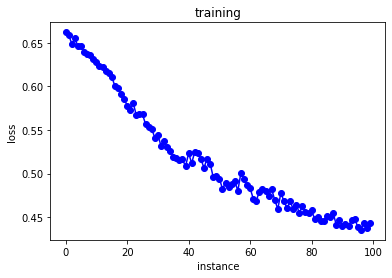

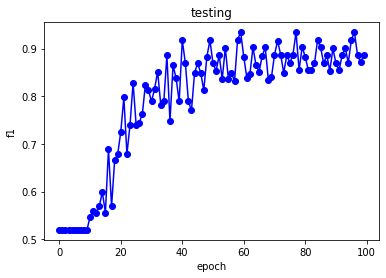

(GRU_classifier(
   (rnn): GRU(200, 64)
   (fc): Linear(in_features=64, out_features=2, bias=True)
   (tanh): Tanh()
   (softmax): Softmax(dim=1)
 ),
 [0.5193962019152735,
  0.5193962019152735,
  0.5193962019152735,
  0.5193962019152735,
  0.5193962019152735,
  0.5193962019152735,
  0.5193962019152735,
  0.5193962019152735,
  0.5193962019152735,
  0.5193962019152735,
  0.546577679863496,
  0.5584279108869272,
  0.555886736214605,
  0.5688558391076559,
  0.5985708280790248,
  0.555886736214605,
  0.6887105491018766,
  0.5688558391076559,
  0.6651461154668568,
  0.6783250363184352,
  0.7253328374428322,
  0.7976087760384568,
  0.6788566624632199,
  0.7394007914075749,
  0.8281230143601475,
  0.7395580898075551,
  0.744715786181553,
  0.7619551257837877,
  0.8242307355132814,
  0.8127915765331388,
  0.7890768826159374,
  0.8159953812728846,
  0.851570482917944,
  0.7825399960497729,
  0.7890768826159374,
  0.8858539598585057,
  0.7473816029143898,
  0.8650725173589712,
  0.8376896327716,


In [84]:
hidden_size = 64
output_size = 2
rnn = GRU_classifier(200, hidden_size, output_size, category_list)
train_rnn(rnn, train_loader, test_loader, epochs=100,  learning_rate=0.01)

In [7]:
import joblib

In [8]:
path = 'C:/Users/zgeme/OneDrive - Tulane University/NLP course/gzhang1-master/project/'

In [15]:
joblib.dump(clf, path +'rnn_surgery_or_medicine.pkl')

In [91]:
binary_data.iloc[1].feature_clear

'this year old male presents to abcd general hospital with the above chief complaint the patient states that he has had degenerative joint disease in his left first mpj for many years that has been progressively getting worse and more painful over time the patient desires surgical treatment'

In [92]:
binary_data.iloc[1].medical_specialty

' Surgery'

In [16]:
rnn = joblib.load(rnn_model)

In [17]:
rnn

GRU_classifier(
  (rnn): GRU(200, 64)
  (fc): Linear(in_features=64, out_features=2, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)

In [28]:
input = torch.zeros(1, 1, 200)
input.shape

torch.Size([1, 1, 200])

In [29]:
#x2 = input.unsqueeze(0)
rnn_predict = rnn.forward(input)

In [33]:
topn, top1 = rnn_predict.topk(1)

In [34]:
int(top1)

0

In [35]:
float(topn)

0.732407808303833